In [1]:
import torch.nn as nn
import torch

In [2]:
torch.cuda.empty_cache() 

In [3]:
torch.cuda.is_available()

True

%%bash
git commit -a -m "studying basic stats further  "

https://www.rileynwong.com/blog/2019/2/25/generating-music-with-an-lstm-neural-network

In [ ]:
from IPython.core.debugger import Pdb

In [ ]:
print(device)

# basic library loading

In [4]:
from plotnine import *

import pandas as pd

import numpy as np

# data preparation

In [5]:
max_sequence_length = 100

In [6]:
def split_list(l, n):
    """
    リストをサブリストに分割する
    :param l: リスト
    :param n: サブリストの要素数
    :return: 
    """
    for idx in range(0, len(l), n):
        yield l[idx:idx + n]

In [7]:
import glob

import score2df

In [8]:
import score2df

In [9]:
from importlib import reload

In [ ]:
reload(score2df)

## 差分バージョン

In [10]:
is_difference_based = True

In [11]:
is_discrete = True

In [12]:
from music21 import converter, instrument, note, chord

In [13]:
id = str(is_difference_based) + "_"  + str(is_discrete)

In [14]:
pkl_path = 'saved/seq_df_scores_{}.pkl'.format(id)

In [15]:
is_use_preprocessed_df = True

In [16]:
df_scores = pd.DataFrame()
if is_use_preprocessed_df:
    df_scores = pd.read_pickle(pkl_path)
else:
    for file in glob.glob("chorales/midi/*.mid"):
        df_score = score2df.score2dataframe(file)
        df_score = score2df.add_sequential_diffs(df_score)
        df_score = df_score.assign(file = file)
        df_scores = df_scores.append(df_score , ignore_index = True )
        
    df_scores.to_pickle(pkl_path)

In [ ]:
df_scores.head()

In [ ]:
df_scores.describe()

In [ ]:
ggplot(df_scores , aes(x = 'dt' , y = 'dcent' , color = 'n')) + geom_point() + theme_minimal()

In [ ]:
ggplot(df_scores.query('dt == 0') , aes(color = 'n' , x = 'dcent')) + geom_histogram() + facet_wrap('~n') + theme_void()

## preprocess 2

In [17]:
if is_discrete:
    dtype = str
else:
    dtype = np.float64

In [18]:
notes_list = []
dt_list = []
for f in set(df_scores.file):
    df_file = df_scores[df_scores.file == f]

    run_notes = df_file.dcent.astype(dtype)
    run_dts = df_file.dt.astype(dtype)
    for n in split_list(run_notes , max_sequence_length):
        if len(n) > 10:
            notes_list.append(n)
    for n in split_list(run_dts , max_sequence_length):
        if len(n) > 10:
            dt_list.append(n)
        

In [ ]:
len(notes_list)

In [ ]:
len(dt_list)

In [ ]:
len(notes_list[0])

In [ ]:
len(dt_list[0])

#### linear regresssion


https://www.statsmodels.org/dev/example_formulas.html

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [ ]:
mod = smf.ols(formula = 'dcent ~ dcent_lag1' , data = df_stage)

In [ ]:
res = mod.fit()

print(res.summary())

https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5

## pre-pack procedures

In [19]:
from music21 import converter, instrument, note, chord

### with label encoding (for discrete version)
https://towardsdatascience.com/encoding-categorical-features-21a2651a065c
に概ね準拠仕様と思ったが・・・

- そもそもlabelencoder -> onehot  は今後必要ないよとwarning が出る
- onehot の挙動が読みにくい

のでlabelencodingしたあと直にnp.arrayをmanual onehote化したほうがいいのではないか？？

In [80]:
raw_y1, raw_X1 , le1 = score2df.yx_encoder(notes_list)

In [79]:
raw_y2, raw_X2 , le2 = score2df.yx_encoder(dt_list)

In [22]:
raw_X = [torch.cat((raw_X1[i] , raw_X2[i]) , 1) for i in range(len(raw_X1))]

## pad and pack

In [23]:
packed_X = torch.nn.utils.rnn.pack_sequence(raw_X , enforce_sorted=False)

ppd_X = torch.nn.utils.rnn.pad_packed_sequence(packed_X)

In [24]:
packed_y1 = torch.nn.utils.rnn.pack_sequence(raw_y1 , enforce_sorted=False)

ppd_y1 = torch.nn.utils.rnn.pad_packed_sequence(packed_y1)

In [25]:

packed_y2 = torch.nn.utils.rnn.pack_sequence(raw_y2 , enforce_sorted=False)

ppd_y2 = torch.nn.utils.rnn.pad_packed_sequence(packed_y2)

### reference

- [OneHotEncoderだけでいける。LabelEncoderをかます必要なし]と当初思っていたがむしろ逆



https://stackoverflow.com/questions/30869382/encoding-string-to-numbers-so-as-to-use-it-in-scikit-learn

Another possible good reference:
https://stackoverflow.com/questions/30869382/encoding-string-to-numbers-so-as-to-use-it-in-scikit-learn


## mask

In [ ]:
mask = torch.Tensor([len(x) - 1 for x in notes_list])
                     

or

In [26]:
mask = ppd_X[1]

# LTSM

参考文献のpreprocessはあまり納得いかないので・・

https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html

をみつつやってみるか

## 参考文献に似せたモデル
https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
に似せたモデル


softmaxを二重にかけないように注意

In [27]:
class my_model(nn.Module):

    def __init__(self, input_size1 , input_size2, hidden_size, num_layers , dropout):
        #super(my_model, self).__init__()
        
        super().__init__()

        self.relu = nn.ReLU()
        
        input_size = input_size1 + input_size2
        


        self.rnn = nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers , dropout=dropout)

        self.linear1 = nn.Linear(hidden_size, input_size1) #output dimension has to be identical with the input dimension
        
        self.linear2 = nn.Linear(hidden_size, input_size2) #output dimension has to be identical with the input dimension
        
     


    def forward(self, input):
        #self.h0 = torch.randn(self.num_layers , sequence_num , self.hidden_size)
        #self.c0 = torch.randn(self.num_layers , sequence_num, self.hidden_size)
        y, (hn, cn) = self.rnn(input)#, (self.h0, self.c0))
        y1 = self.linear1(y)
        y1 = self.relu(y1)
        y2 = self.linear2(y)
        y2 = self.relu(y2)
       
        return y1,y2
    

In [28]:
input_size1 = raw_X1[0].shape[1]
input_size2 = raw_X2[0].shape[1]
hidden_size = 256 
num_layers = 2
dropout = 0.1

In [29]:
model = my_model(input_size1 , input_size2 , hidden_size , num_layers , dropout)

## dimensionality check

In [30]:
y_tmp1 ,y_tmp2 = model.forward(ppd_X[0][:, 0:10])

In [31]:
y_tmp1.shape

torch.Size([99, 10, 108])

In [32]:
y_tmp2.shape

torch.Size([99, 10, 61])

##    連続バージョン

https://stackoverflow.com/questions/49040180/change-tanh-activation-in-lstm-to-relu

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, nlayers, dropout):
        """"Constructor of the class"""
        super(LSTMCell, self).__init__()

        self.nlayers = nlayers
        self.dropout = nn.Dropout(p=dropout)

        ih, hh = [], []
        for i in range(nlayers):
            ih.append(nn.Linear(input_size, 4 * hidden_size))
            hh.append(nn.Linear(hidden_size, 4 * hidden_size))
        self.w_ih = nn.ModuleList(ih)
        self.w_hh = nn.ModuleList(hh)

    def forward(self, input, hidden):
        """"Defines the forward computation of the LSTMCell"""
        hy, cy = [], []
        for i in range(self.nlayers):
            hx, cx = hidden[0][i], hidden[1][i]
            gates = self.w_ih[i](input) + self.w_hh[i](hx)
            i_gate, f_gate, c_gate, o_gate = gates.chunk(4, 1)

            i_gate = F.sigmoid(i_gate)
            f_gate = F.sigmoid(f_gate)
            c_gate = F.tanh(c_gate)
            o_gate = F.sigmoid(o_gate)

            ncx = (f_gate * cx) + (i_gate * c_gate)
            nhx = o_gate * F.tanh(ncx)
            cy.append(ncx)
            hy.append(nhx)
            input = self.dropout(nhx)

        hy, cy = torch.stack(hy, 0), torch.stack(cy, 0)
        return hy, cy

# criterion (cross entropy lossはlog softmaxを含んでいるので二重に作用させないよう注意が必要）

cross entropy for one-hot representation
https://discuss.pytorch.org/t/cross-entropy-with-one-hot-targets/13580/4

one-hotのままでなくて、Rでいうところのfactorに戻したほうがよさそう（？）


In [33]:
criterion = nn.CrossEntropyLoss(reduction='sum')


input has to be a Tensor of size either (minibatch, C)(minibatch,C) or (minibatch, C, d_1, d_2, ..., d_K)

# GPU tool

In [34]:
is_use_gpu = True


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() and is_use_gpu else "cpu")

# optimizer

In [36]:
import torch.optim as optim# optimizer

In [ ]:
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [37]:
optimizer = optim.Adam(model.parameters())

# optimization

In [38]:
from IPython.display import display

In [39]:
sample_size = ppd_X[0].shape[1]

In [40]:
print("sample size : {}".format(sample_size))

sample size : 2591


In [41]:
batch_size = 20

In [42]:
batch_indices = range( 0 ,sample_size ,  batch_size)

## n epochs

In [44]:
losses1 = []
losses2 = []

In [45]:
prob_when_random1 = 1 /input_size1

In [46]:
prob_when_random2 = 1 / input_size2

In [47]:
reload(score2df)

<module 'score2df' from '/home/toshinao/PycharmProjects/deepjazz_in_a_file/score2df.py'>

In [49]:
model_path = 'saved/model20191124_{}'.format(id)

In [43]:
n_epochs = 500

In [56]:
model.to(device)
model.train()
for k in range(n_epochs):
    batch_loss1 = 0
    batch_loss2 = 0

    shuffled_idx = torch.randperm(sample_size)
    for i in batch_indices:
        #display(".")
        batch_samples = shuffled_idx[i:min(i + batch_size , sample_size) ]

        loss1, loss2 = score2df.batch_loss_2vars(ppd_y1, ppd_y2 , ppd_X , mask , batch_samples , device , model , criterion)
        batch_loss1 += loss1.item()
        batch_loss2 += loss2.item()
        loss = loss1 + loss2

        
        loss.backward()

        optimizer.step()
    batch_loss1 /= torch.sum(mask).item()
    losses1.append(batch_loss1)
    mean_correct_prob1 = np.exp(-batch_loss1)
    batch_loss2 /= torch.sum(mask).item()
    losses2.append(batch_loss2)
    mean_correct_prob2 = np.exp(-batch_loss2)    
    if k % 10 == 0:
        torch.save(model.state_dict() , model_path)
        display("epoch : {}".format(k))
        display("  [dcent] loss : {}   correct prob : {} correct / random : {}".format(batch_loss1 ,
                                                                        mean_correct_prob1 ,
                                                                        mean_correct_prob1 / prob_when_random1))
        
        display("  [dt] loss : {}   correct prob : {} correct / random : {}".format(batch_loss2 ,
                                                                        mean_correct_prob2 ,
                                                                        mean_correct_prob2 / prob_when_random2))

model.cpu()
torch.cuda.empty_cache() 

'epoch : 0'

'  [dcent] loss : 3.968840743107741   correct prob : 0.018895324979277938 correct / random : 2.0406950977620175'

'  [dt] loss : 0.5163939363582484   correct prob : 0.5966682970350221 correct / random : 36.396766119136345'

'epoch : 10'

'  [dcent] loss : 3.8837325295634577   correct prob : 0.020573889038747493 correct / random : 2.2219800161847294'

'  [dt] loss : 0.4640729543989177   correct prob : 0.6287176850731283 correct / random : 38.35177878946082'

'epoch : 20'

'  [dcent] loss : 3.803902943580152   correct prob : 0.022283630160945353 correct / random : 2.4066320573820983'

'  [dt] loss : 0.41340754181011385   correct prob : 0.6613926827238094 correct / random : 40.34495364615237'

'epoch : 30'

'  [dcent] loss : 3.5240716475005067   correct prob : 0.029479161723369982 correct / random : 3.1837494661239583'

'  [dt] loss : 0.36834773863636966   correct prob : 0.6918765476450639 correct / random : 42.2044694063489'

'epoch : 40'

'  [dcent] loss : 3.4168999707043204   correct prob : 0.032814001794437775 correct / random : 3.54391219379928'

'  [dt] loss : 0.3290824532503315   correct prob : 0.7195836822874594 correct / random : 43.89460461953502'

'epoch : 50'

'  [dcent] loss : 3.3209010662295064   correct prob : 0.03612027033045452 correct / random : 3.9009891956890885'

'  [dt] loss : 0.29211371381038764   correct prob : 0.7466836229056397 correct / random : 45.54770099724402'

'epoch : 60'

'  [dcent] loss : 3.1286962525603834   correct prob : 0.04377483138996138 correct / random : 4.727681790115829'

'  [dt] loss : 0.26579576874265587   correct prob : 0.7665956743130384 correct / random : 46.76233613309534'

'epoch : 70'

'  [dcent] loss : 3.0410123138396172   correct prob : 0.04778649007538081 correct / random : 5.160940928141128'

'  [dt] loss : 0.23878425247789395   correct prob : 0.7875847835096449 correct / random : 48.042671794088335'

'epoch : 80'

'  [dcent] loss : 2.9538867472344297   correct prob : 0.05213666957222581 correct / random : 5.630760313800388'

'  [dt] loss : 0.22057141877795514   correct prob : 0.8020603546456949 correct / random : 48.925681633387384'

'epoch : 90'

'  [dcent] loss : 2.8836636032205165   correct prob : 0.05592948359667397 correct / random : 6.040384228440789'

'  [dt] loss : 0.20262699917259533   correct prob : 0.8165827706763547 correct / random : 49.81154901125763'

'epoch : 100'

'  [dcent] loss : 2.820535185583604   correct prob : 0.059574051002456385 correct / random : 6.43399750826529'

'  [dt] loss : 0.18755537156996763   correct prob : 0.8289832148074605 correct / random : 50.56797610325509'

'epoch : 110'

'  [dcent] loss : 2.767288578297671   correct prob : 0.06283213840954903 correct / random : 6.785870948231295'

'  [dt] loss : 0.17703388159186179   correct prob : 0.837751399691129 correct / random : 51.10283538115887'

'epoch : 120'

'  [dcent] loss : 2.72236248216075   correct prob : 0.06571931018365074 correct / random : 7.09768549983428'

'  [dt] loss : 0.16737794538150363   correct prob : 0.8458798545313634 correct / random : 51.598671126413166'

'epoch : 130'

'  [dcent] loss : 2.6856719746171827   correct prob : 0.06817536648478542 correct / random : 7.362939580356826'

'  [dt] loss : 0.16082244599435583   correct prob : 0.8514432348438157 correct / random : 51.938037325472756'

'epoch : 140'

'  [dcent] loss : 2.6508787939199405   correct prob : 0.07058915247718128 correct / random : 7.623628467535579'

'  [dt] loss : 0.1534688567661148   correct prob : 0.8577274761902776 correct / random : 52.321376047606925'

'epoch : 150'

'  [dcent] loss : 2.618232446773112   correct prob : 0.07293165955655728 correct / random : 7.876619232108187'

'  [dt] loss : 0.14555178208584077   correct prob : 0.8645451209651775 correct / random : 52.73725237887583'

'epoch : 160'

'  [dcent] loss : 2.598777375103484   correct prob : 0.07436444247534717 correct / random : 8.031359787337495'

'  [dt] loss : 0.14213312792280755   correct prob : 0.867505759558358 correct / random : 52.91785133305983'

'epoch : 170'

'  [dcent] loss : 2.57392353835879   correct prob : 0.07623584360589067 correct / random : 8.233471109436193'

'  [dt] loss : 0.13584326445795458   correct prob : 0.8729794486735422 correct / random : 53.25174636908607'

'epoch : 180'

'  [dcent] loss : 2.5521909603017243   correct prob : 0.0779107794418449 correct / random : 8.414364179719248'

'  [dt] loss : 0.13178487975213451   correct prob : 0.8765295340499974 correct / random : 53.46830157704984'

'epoch : 190'

'  [dcent] loss : 2.538601840608617   correct prob : 0.07897674471012392 correct / random : 8.529488428693384'

'  [dt] loss : 0.1289166315131978   correct prob : 0.8790472473296825 correct / random : 53.621882087110635'

'epoch : 200'

'  [dcent] loss : 2.5246521610044512   correct prob : 0.08008616503359357 correct / random : 8.649305823628106'

'  [dt] loss : 0.1248313410850961   correct prob : 0.8826457561069753 correct / random : 53.841391122525486'

'epoch : 210'

'  [dcent] loss : 2.51670734134692   correct prob : 0.08072496940449445 correct / random : 8.718296695685401'

'  [dt] loss : 0.12452728979601735   correct prob : 0.8829141664901132 correct / random : 53.8577641558969'

'epoch : 220'

'  [dcent] loss : 2.5022779783797984   correct prob : 0.08189822358724298 correct / random : 8.845008147422243'

'  [dt] loss : 0.12090054361776835   correct prob : 0.8861220857073107 correct / random : 54.05344722814595'

'epoch : 230'

'  [dcent] loss : 2.48929863056425   correct prob : 0.08296813748891342 correct / random : 8.96055884880265'

'  [dt] loss : 0.11843385267001462   correct prob : 0.8883105730860669 correct / random : 54.18694495825007'

'epoch : 240'

'  [dcent] loss : 2.4796722041497468   correct prob : 0.08377068077363334 correct / random : 9.047233523552402'

'  [dt] loss : 0.1144781533546319   correct prob : 0.8918314217301005 correct / random : 54.40171672553613'

'epoch : 250'

'  [dcent] loss : 2.4769064742231657   correct prob : 0.08400268853993961 correct / random : 9.07229036231348'

'  [dt] loss : 0.11507399836589444   correct prob : 0.8913001867091611 correct / random : 54.369311389258826'

'epoch : 260'

'  [dcent] loss : 2.4667677310175473   correct prob : 0.08485870234696002 correct / random : 9.164739853471684'

'  [dt] loss : 0.11332775960422835   correct prob : 0.8928579693778601 correct / random : 54.46433613204946'

'epoch : 270'

'  [dcent] loss : 2.4603035070821444   correct prob : 0.08540902478922834 correct / random : 9.224174677236661'

'  [dt] loss : 0.10924419019630686   correct prob : 0.8965114714548789 correct / random : 54.68719975874761'

'epoch : 280'

'  [dcent] loss : 2.458014201916238   correct prob : 0.08560477609263538 correct / random : 9.245315818004622'

'  [dt] loss : 0.11074077195446085   correct prob : 0.8951707722239665 correct / random : 54.60541710566195'

'epoch : 290'

'  [dcent] loss : 2.451492614420182   correct prob : 0.08616487952662959 correct / random : 9.305806988875997'

'  [dt] loss : 0.10916569554152554   correct prob : 0.8965818455752982 correct / random : 54.69149258009319'

'epoch : 300'

'  [dcent] loss : 2.4481840427816843   correct prob : 0.08645043433204225 correct / random : 9.336646907860564'

'  [dt] loss : 0.10756658526212015   correct prob : 0.8980167257809618 correct / random : 54.77902027263867'

'epoch : 310'

'  [dcent] loss : 2.445225099999723   correct prob : 0.08670661504583099 correct / random : 9.364314424949749'

'  [dt] loss : 0.10643348209649707   correct prob : 0.8990348480855973 correct / random : 54.84112573322143'

'epoch : 320'

'  [dcent] loss : 2.4370719049898586   correct prob : 0.08741644072844171 correct / random : 9.440975598671704'

'  [dt] loss : 0.10523001670833376   correct prob : 0.9001174567183657 correct / random : 54.907164859820305'

'epoch : 330'

'  [dcent] loss : 2.4325077089749683   correct prob : 0.08781633841033508 correct / random : 9.484164548316189'

'  [dt] loss : 0.10319452248771431   correct prob : 0.9019515065650845 correct / random : 55.01904190047015'

'epoch : 340'

'  [dcent] loss : 2.4311473527914775   correct prob : 0.08793588120125533 correct / random : 9.497075169735576'

'  [dt] loss : 0.10200464602562934   correct prob : 0.9030253561801819 correct / random : 55.08454672699109'

'epoch : 350'

'  [dcent] loss : 2.427813698572042   correct prob : 0.08822951819282122 correct / random : 9.528787964824692'

'  [dt] loss : 0.10172549956354207   correct prob : 0.903277467699917 correct / random : 55.099925529694936'

'epoch : 360'

'  [dcent] loss : 2.4264939708314164   correct prob : 0.08834603400318479 correct / random : 9.541371672343958'

'  [dt] loss : 0.10202660700316006   correct prob : 0.9030055250783812 correct / random : 55.08333702978125'

'epoch : 370'

'  [dcent] loss : 2.4251338423996978   correct prob : 0.08846627771076775 correct / random : 9.554357992762917'

'  [dt] loss : 0.10207614555781895   correct prob : 0.9029607925978201 correct / random : 55.080608348467024'

'epoch : 380'

'  [dcent] loss : 2.424617720814268   correct prob : 0.08851194885119378 correct / random : 9.559290475928929'

'  [dt] loss : 0.10093535461050919   correct prob : 0.9039914698776693 correct / random : 55.14347966253783'

'epoch : 390'

'  [dcent] loss : 2.4222422554009446   correct prob : 0.08872245585141673 correct / random : 9.582025231953008'

'  [dt] loss : 0.09976776994893026   correct prob : 0.9050475728769501 correct / random : 55.20790194549396'

'epoch : 400'

'  [dcent] loss : 2.4171884786112354   correct prob : 0.08917197426563947 correct / random : 9.630573220689064'

'  [dt] loss : 0.09844558482722557   correct prob : 0.9062450047511039 correct / random : 55.28094528981734'

'epoch : 410'

'  [dcent] loss : 2.4211001462178747   correct prob : 0.0888238444704045 correct / random : 9.592975202803688'

'  [dt] loss : 0.1000639790668997   correct prob : 0.9047795292341132 correct / random : 55.1915512832809'

'epoch : 420'

'  [dcent] loss : 2.415286199967326   correct prob : 0.08934176565198283 correct / random : 9.648910690414146'

'  [dt] loss : 0.09918927722668971   correct prob : 0.9055712877791654 correct / random : 55.23984855452909'

'epoch : 430'

'  [dcent] loss : 2.412962961848441   correct prob : 0.08954956914258212 correct / random : 9.67135346739887'

'  [dt] loss : 0.09885834565705731   correct prob : 0.905871019499453 correct / random : 55.25813218946663'

'epoch : 440'

'  [dcent] loss : 2.4119386704091443   correct prob : 0.08964134099218384 correct / random : 9.681264827155855'

'  [dt] loss : 0.0980544823310783   correct prob : 0.9065995087537644 correct / random : 55.30257003397963'

'epoch : 450'

'  [dcent] loss : 2.4101847880184613   correct prob : 0.08979869931528567 correct / random : 9.698259526050853'

'  [dt] loss : 0.09720313772009107   correct prob : 0.907371665999183 correct / random : 55.34967162595016'

'epoch : 460'

'  [dcent] loss : 2.4078153111370346   correct prob : 0.09001172754035346 correct / random : 9.721266574358173'

'  [dt] loss : 0.09725444151200927   correct prob : 0.9073251155861546 correct / random : 55.346832050755424'

'epoch : 470'

'  [dcent] loss : 2.4089978220417483   correct prob : 0.08990535059932711 correct / random : 9.709777864727329'

'  [dt] loss : 0.0969212483015798   correct prob : 0.907627480524495 correct / random : 55.365276311994194'

'epoch : 480'

'  [dcent] loss : 2.4042746264343293   correct prob : 0.09033099556728866 correct / random : 9.755747521267175'

'  [dt] loss : 0.09618254425205601   correct prob : 0.9082981963195546 correct / random : 55.40618997549282'

'epoch : 490'

'  [dcent] loss : 2.4054531326178332   correct prob : 0.09022460263512865 correct / random : 9.744257084593894'

'  [dt] loss : 0.09590677115376599   correct prob : 0.908548715068903 correct / random : 55.42147161920308'

### load model

https://qiita.com/jyori112/items/aad5703c1537c0139edb

In [ ]:
model = my_model(input_size , hidden_size , num_layers , dropout)
model.load_state_dict(torch.load(model_path, map_location='cpu'))

## check error

In [53]:
import matplotlib.pyplot as plt
%matplotlib inline

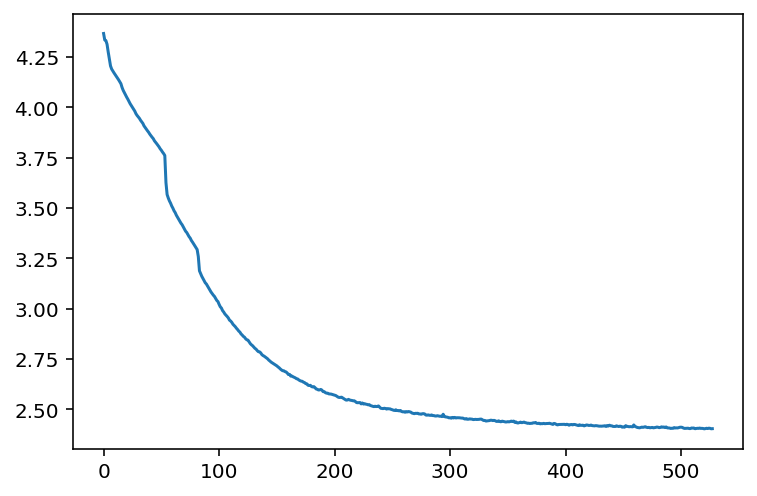

In [57]:
plt.plot(losses1)

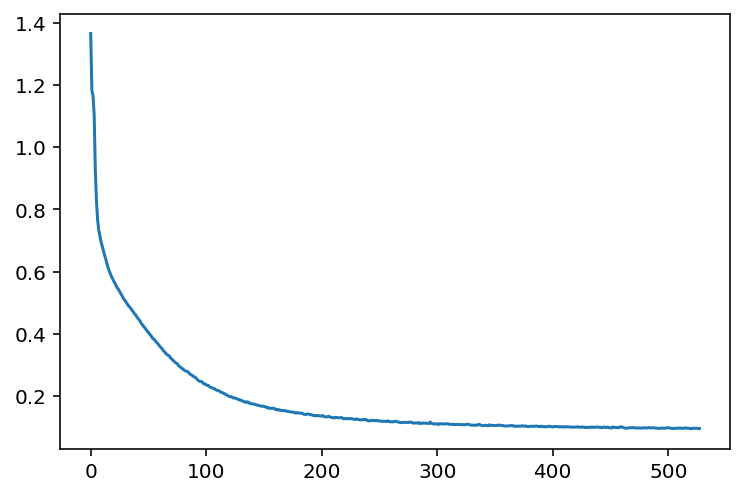

In [58]:
plt.plot(losses2)

## check errors using plotnine

In [ ]:
ggplot(pd.DataFrame({'n':range(len(losses)) , 'loss':losses}) , aes(x = 'n' , y ='loss')) + geom_point()

## predicted vs realized

In [59]:
model.eval()

my_model(
  (relu): ReLU()
  (rnn): LSTM(169, 256, num_layers=2, dropout=0.1)
  (linear1): Linear(in_features=256, out_features=108, bias=True)
  (linear2): Linear(in_features=256, out_features=61, bias=True)
)

In [60]:
model.to(device)

my_model(
  (relu): ReLU()
  (rnn): LSTM(169, 256, num_layers=2, dropout=0.1)
  (linear1): Linear(in_features=256, out_features=108, bias=True)
  (linear2): Linear(in_features=256, out_features=61, bias=True)
)

In [95]:
y_pred1, y_pred2 = model(ppd_X[0].to(device))

In [88]:
from itertools import chain

In [92]:
reload(score2df)

<module 'score2df' from '/home/toshinao/PycharmProjects/deepjazz_in_a_file/score2df.py'>

In [96]:
df_scatter = score2df.predicted_vs_realized(y_pred1 , ppd_y1 , le1)

In [94]:
y_pred1_idx = y_pred1.detach().cpu().numpy().argmax(axis = 2)

y_pred1 = [[float(le1.classes_[x]) for x in y_pred1_idx[0:mask.numpy()[i] , i]] for i in range(y_pred1_idx.shape[1])]

y_realized1 = [[float(le1.classes_[x]) for x in ppd_y1[0].cpu().numpy()[0:mask.numpy()[i] , i]] for i in range(y_pred1_idx.shape[1])]

df_scatter = pd.DataFrame({'pred':chain.from_iterable(y_pred1) , 'realized':chain.from_iterable(y_realized1)})

AttributeError: 'list' object has no attribute 'detach'

In [97]:
df_scatter.head()

,pred,realized
0,1200.0,1600.0
1,0.0,300.0
2,500.0,500.0
3,200.0,200.0
4,1200.0,200.0


/home/toshinao/anaconda3/envs/test/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/toshinao/anaconda3/envs/test/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


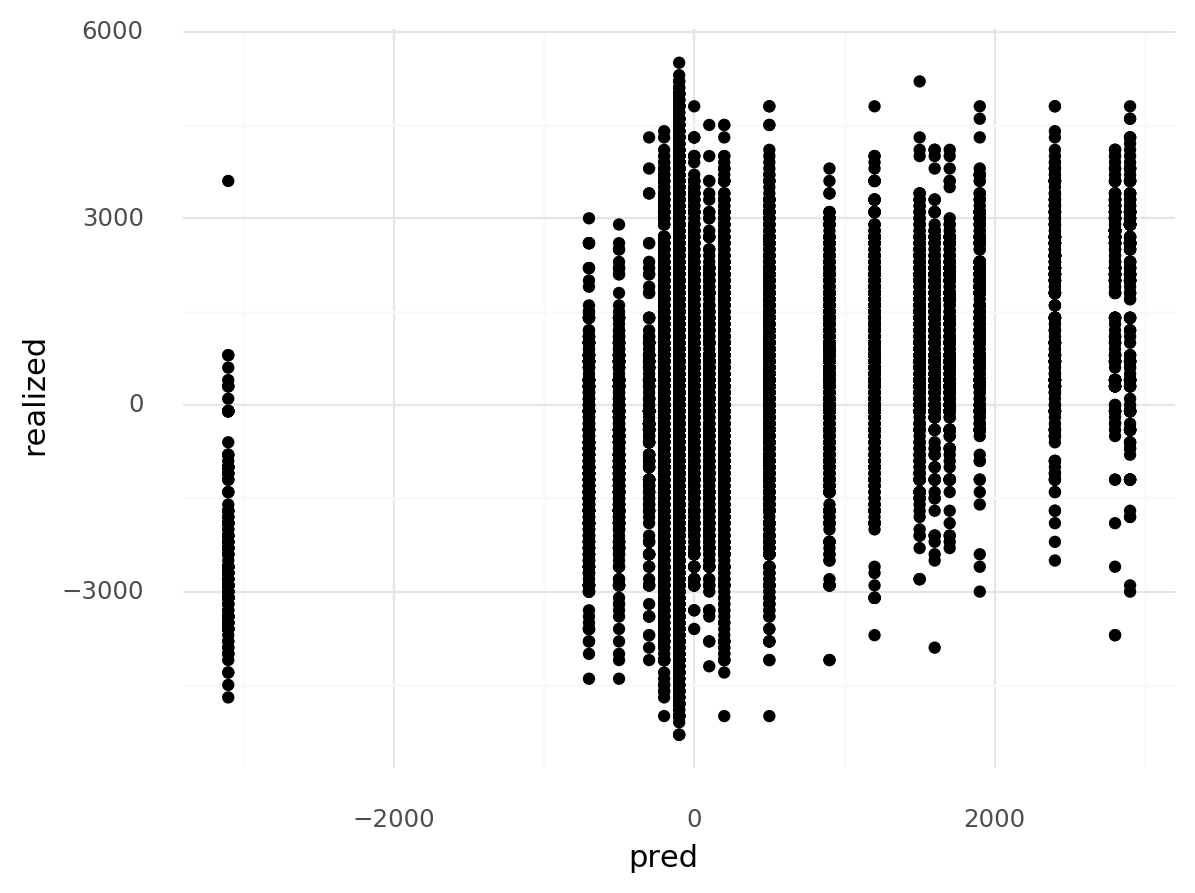

<ggplot: (-9223363291297054404)>

In [98]:
ggplot(df_scatter , aes(x = 'pred', y = 'realized')) + geom_point() + theme_minimal()

In [99]:
df_scatter = score2df.predicted_vs_realized(y_pred2 , ppd_y2 , le1)

/home/toshinao/anaconda3/envs/test/lib/python3.7/site-packages/plotnine/scales/scale.py:93: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cbook.iterable(self.breaks) and cbook.iterable(self.labels):
/home/toshinao/anaconda3/envs/test/lib/python3.7/site-packages/plotnine/utils.py:553: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  return cbook.iterable(var) and not is_string(var)


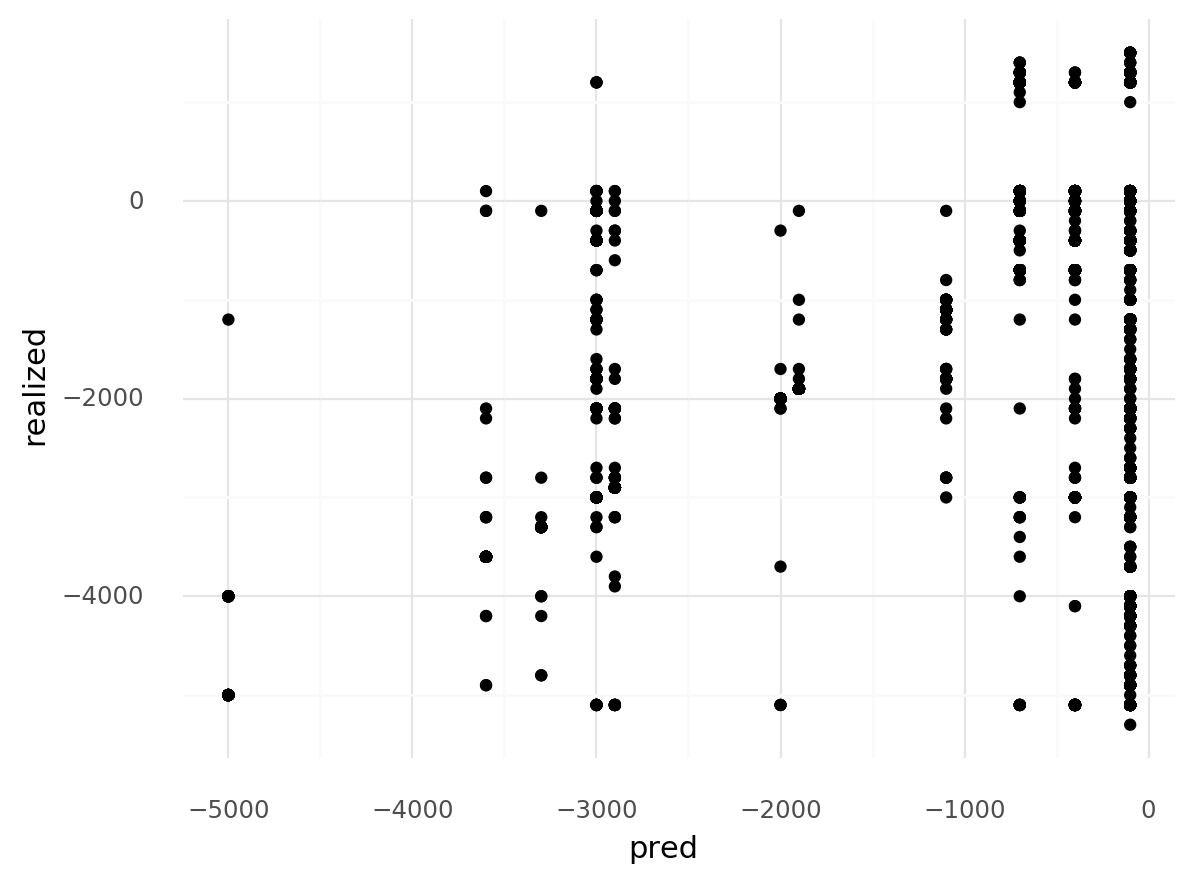

<ggplot: (8745558274624)>

In [100]:
ggplot(df_scatter , aes(x = 'pred', y = 'realized')) + geom_point() + theme_minimal()

# generating music

In [ ]:
device = torch.device("cpu")

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
model.eval()

In [ ]:
x_gen = np.zeros(input_size , dtype = "float32")

In [ ]:
x_gen[0] = 1.

In [ ]:
x_gen = x_gen.reshape([1,1,-1])

In [ ]:
x_gen = torch.tensor(x_gen).to(device)

In [ ]:
model = model.to(device)

In [ ]:
N_gen = 100

In [ ]:
for i in range(N_gen):    
    x1 = model.forward(x_gen)
    x_gen = torch.cat([x_gen, x1[-1:]] , dim = 0)

In [ ]:
x_gen.shape

## alternative generation method

一番後ろだけアップデートするのでなく、まるごと（最初以外）置き換える手法も試してみる

In [ ]:
device = torch.device("cpu")

In [ ]:
x_gen = np.zeros(input_size , dtype = "float32")

In [ ]:
x_gen[0] = 1.

In [ ]:
x_gen = x_gen.reshape([1,1,-1])

In [ ]:
x_gen = torch.tensor(x_gen).to(device)

In [ ]:
model = model.to(device)

In [ ]:
N_gen = 100

In [ ]:
for i in range(N_gen):    
    x1 = model.forward(x_gen)
    x_gen = torch.cat([x_gen[:1] , x1] , dim = 0)

In [ ]:
x_gen.shape

## to score

In [ ]:
x_gen2 = x_gen.cpu().detach().numpy()

In [ ]:
x_gen2.shape

In [ ]:
xidx_gen = x_gen2.argmax(axis = 2).reshape(-1)

In [ ]:
xidx_gen.shape

In [ ]:
shift_gen= np.array( [float(le.classes_[xidx_gen[i]]) for i in range(xidx_gen.shape[0])])

In [ ]:
shift_cumsum_gen = shift_gen.cumsum()

In [ ]:
from music21 import *

In [ ]:
st1=stream.Stream()

In [ ]:
dt = 0.5
base_note = note.Note("C5")

In [ ]:
for i in range(shift_cumsum_gen.shape[0]):
    run_shift = int(shift_cumsum_gen[i] / 100)
    if run_shift == 0:
        run_note = base_note
    else:                                      
        run_note = base_note.transpose(interval.ChromaticInterval(run_shift))
    st1.insert(0.5 * i , run_note)

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename=st1.write('lily.png'))

## to midi file

In [ ]:
st1.write('midi', fp ='tmp/rnn_generated.midi' )

## playing sound (fail)

jupyter lab上でのmidiファイル再生はいまのところできていない。一度ファイルに落として、jupyter notebook(labではなく）でplay_sound.ipynbで確認するのが現段階での最善手


In [ ]:
import pygame
freq = 44100    # audio CD quality
bitsize = -16   # unsigned 16 bit
channels = 2    # 1 is mono, 2 is stereo
buffer = 1024    # number of samples
pygame.mixer.init(freq, bitsize, channels, buffer)
pygame.mixer.music.set_volume(0.8)

In [ ]:
sp = midi.realtime.StreamPlayer(st1)
sp.play()

In [ ]:
st1.show('midi')

# 比較用にlinear modelを用いてgenerate

In [ ]:
df_stage.columns

In [ ]:
sequence_gen = [800,200,0]

In [ ]:
N_gen = 100

noise_strength = 0.1 #1にするとmseの誤差項の大きさをそのまま使う

In [ ]:
for i in range(N_gen):
    df_gen = pd.DataFrame({'dcent_lag1':[sequence_gen[-1]] , 'dcent_lag2':[sequence_gen[-2]] , 'dcent_lag3':[sequence_gen[-3]]})
    sequence_gen.append(int(res.predict(df_gen + noise_strength * np.sqrt(res.mse_resid) * np.random.normal()) / 100) * 100)

In [ ]:
sequence_gen[0:20]

In [ ]:
shift_cumsum_gen = np.array(sequence_gen).cumsum() 

In [ ]:
st1=stream.Stream()

In [ ]:
dt = 0.5
base_note = note.Note("C5")

In [ ]:
for i in range(shift_cumsum_gen.shape[0]):
    run_shift = int(shift_cumsum_gen[i] / 100)
    if run_shift == 0:
        run_note = base_note
    else:                                      
        run_note = base_note.transpose(interval.ChromaticInterval(run_shift))
    st1.insert(0.5 * i , run_note)

In [ ]:
run_shift == 0

In [ ]:
from IPython.display import Image

In [ ]:
Image(filename=st1.write('lily.png'))

## to midi file

In [ ]:
st1.write('midi', fp ='tmp/tmp.midi' )

## sandbox

In [ ]:
tmp = note.Note("D5")

In [ ]:
tmp.transpose(interval.GenericInterval(1))

In [ ]:
y_tmp = model.forward(ppd_X[0][:, 0:10].to(device))

In [ ]:
,rex0 = np.zeros(input_size , dtype = "float32")

In [ ]:
x0[0] = 1.

In [ ]:
x0 = x0.reshape([1,1,-1])

In [ ]:
x0 = torch.tensor(x0).to(device)

In [ ]:
model = model.to(device)

In [ ]:
x1 = model.forward(x0)

In [ ]:
x1.shape

In [ ]:
x = torch.cat([x0, x1] , dim = 0)

In [ ]:
x2 = model.forward(x)

In [ ]:
x2.shape

In [ ]:
x2[-2:-1].shape

In [ ]:
x = torch.cat([x, x2[-2:-1]] , dim = 0)

# my own try and error　（この節のプロセスは必要ない）

# Before starting the note...
Useful tips for jupyter notebook:

https://www.dataquest.io/blog/jupyter-notebook-tips-tricks-shortcuts/

In [ ]:
#http://d.hatena.ne.jp/naraba/20121201/p1
#http://web.mit.edu/music21/doc/usersGuide/usersGuide_01_installing.html

from music21 import *
#environment.set('musicxmlPath' , r"C:\Program Files (x86)\Finale NotePad 2012\Finale NotePad.exe")
#configure.run()
#environment.keys()
#environment.get('musicxmlPath')

楽譜を表示するためのおまじない

参考URL:https://groups.google.com/forum/#!topic/music21list/FmU6HeNm7AM


In [ ]:
us = environment.UserSettings() #不必要

#us.create()
us['musicxmlPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'
us['musescoreDirectPNGPath'] = r'C:\Program Files (x86)\MuseScore 2\bin\MuseScore.exe'

# install musescore in linux (apt-getでインストールするのがポイント）

For all those who will struggle with displaying scores from music21 within Jupyter Notebook on Linux (e.g. Ubuntu), follow these steps:
https://stackoverflow.com/questions/49939275/python-music21-library-create-png-from-stream/49945456#49945456

MuseScoreのバージョンが2から3にあがっていたので、初期設定のままではうごきませんでした。
https://qiita.com/nofrmm/items/c3662555b145f6b42d92

#us.create()
us['musicxmlPath'] = r'/snap/bin/musescore'
us['musescoreDirectPNGPath'] = r'/snap/bin/musescore'

In [ ]:
environment.set("musescoreDirectPNGPath", "/usr/bin/musescore")
#environment.set("musicxmlPath", "/snap/bin/musescore")

#us.create()
us['musicxmlPath'] = r'/snap/bin/musescore.mscore'
us['musescoreDirectPNGPath'] = r'/snap/bin/musescore.mscore'

In [ ]:
%load_ext music21.ipython21　#不必要

# sandbox

# シンプルな例からスタート

## note
### noteの追加

insert works as expected if it is "Note to Stream"

In [ ]:
st1=stream.Stream()
st1.insert(0,note.Note("B-5"))

In [ ]:
st1.show()

位置を指定して挿入する場合はinsertを使う

In [ ]:
st1=stream.Stream()
st1.insert(0,note.Note("B-4"))
st1.insert(1,note.Note("B-4"))
st1.insert(2,note.Note("B#3"))
st1.insert(3,note.Note("B#3"))
st1.insert(4 , note.Note("B3"))
st1.insert(4 , note.Note("B2"))
st1.insert(5 , note.Note("C4"))
st1.insert(9 , note.Note("C4"))
st1.show()

appendは最後に追加してくれるので位置の指定をしなくてよくて便利

In [ ]:
st1.append(note.Note("C4"))
st1.show()

### 音のシフト
C4をMajor 3rd(長三度)だけシフトした音すなわちE4を追加

In [ ]:
st1=stream.Stream()
st1.insert(0 , note.Note("C4"))
st1.insert(6 , note.Note("C4").transpose("M3"))
st1.show()

E4をdouble diminished 6th（重減６度？）だけシフトした音を追加。
ただし、double diminishedやdouble augumentedが実際に使われることはまれとのこと。
（https://en.wikipedia.org/wiki/Interval_(music)#Main_intervals
を参照。日本語版wikipediaはいまいちなので英語版を見ること）



その他の参考URL：

http://guitarchord-lab.com/theory/interval.html



In [ ]:
st1 = stream.Stream()
st1.append(note.Note("E4"))
st1.append(note.Note("E4").transpose("M6"))
st1.append(note.Note("E4").transpose("m6"))
st1.append(note.Note("E4").transpose("d6"))
st1.append(note.Note("E4").transpose("dd6"))
st1.show()

なお、例えばC4の重減六度なるものは存在しないっぽい。したがって普通にラ（長６度・Major 6th）がappendされてしまう。

In [ ]:
st1=stream.Stream()
st1.append(note.Note("C4"))
st1.append(note.Note("C4").transpose("M6"))
st1.append(note.Note("C4").transpose("m6"))
st1.append(note.Note("C4").transpose("d6"))
st1.append(note.Note("C4").transpose("dd6"))
st1.show()

そして６度には完全６度というものは存在しない

In [ ]:
st1=stream.Stream()
st1.append(note.Note("C4").transpose("P6")) #returns error

完全５度がなぜ完全ともみなされてきたか？それはドとソの周波数比がほぼほぼ2:3になっているから。
すなわち、$2^{7/12}\approx 1.5$であるから：

In [ ]:
print(2**(7/12))

同様に完全４度はほぼほぼ３：４になっている。すなわち、
$2^{5/12}\approx\frac{4}{3}$：

In [ ]:
print(2**(5/12))

（時間的な）offsetの範囲を調べるには以下のようにすればいいだろう（？）

In [ ]:
st1 = stream.Stream()
st1.append(note.Note("E4"))
st1.append(note.Note("E4").transpose("M6"))
st1.append(note.Note("E4").transpose("m6"))
st1.append(note.Note("E4").transpose("d6"))
st1.append(note.Note("E4").transpose("dd6"))
max_offset = max([x.offset for x in st1])
print(max_offset)

最後に付け加えるのをinsertでやるのであれば、以下のようにすればよいだろう

In [ ]:
st1.insert(max_offset + 1 , note.Note("C3"))
st1.show()

appendは以下のようにまとめて行うことができる（ただし、和音を付け加えるような動作ではない）

In [ ]:
st1.append([note.Note("D4") , note.Note("E4")])
st1.show()

以下のように和音を追加することはできない・・

In [ ]:
st1.insert(max_offset + 1 , [note.Note("D4") , note.Note("E4")]) #returns error

あるoffsetの範囲を切り取るには・・・

In [ ]:
st1.getElementsByOffset(0,4).show()

ただし、ヒエラルヒーがある場合の切り取り方はまだ試行削除中・・

### 音の高さの差

#### 半音を100とするfloatで取出

In [ ]:
interval.notesToChromatic(note.Note("D5") , note.Note("D#4")).cents

In [ ]:
run_diff = interval.notesToChromatic(note.Note("D4") , note.Note("D4#"))

In [ ]:
run_diff.cents

#### 逆

In [ ]:
note.Note("C0").transpose(1).nameWithOctave

### 音の大きさ（velocity)

In [ ]:
n= note.Note("B-4")
n.volume.velocity = 200

### テンポ

In [ ]:
run_score = stream.Score()
bpm = 180
run_score.insert(0.0, tempo.MetronomeMark(number=bpm)) 

### 音のoffset

floatで指定されている場合とfraction.fractionで指定されている場合があるので統計処理する場合はfloat()でcastしてやる必要がある

## 楽器の指定、key signature（調記号・調号）の追加など

In [ ]:
st3=stream.Stream()
st3.append(note.Note("C4"))
st3.append(instrument.ElectricGuitar())
st3.append(note.Note("C4"))
st3.append(instrument.Piano())
st3.append(note.Note("C4"))
st3.append(key.KeySignature(1))
st3.append(note.Note("C4"))
st3.append(key.KeySignature(2))

上記でいいのか？
(慣習的にどうかはともかく入力として許容されるのか？)

↑たぶんダメ。楽器はinsertで指定すべき！

In [ ]:
st3.getInstrument()

In [ ]:
[x for x in st3.getInstruments()]

### 楽器名の文字列での取り出し方

In [ ]:
st3.getInstrument().instrumentName

## score, part, measureについて

scoreとPartとMeasureがstreamの基本的なsubclass

scoreがpartを複数含み、partはmeasureを複数持つ、というのが基本的なScoreの構成（deep jazzの例のようにそうでないヒエラルヒーを持つ場合もある）。
この「基本的な構成」を持つ例としてバッハの楽譜xmlファイルを読み込む

In [ ]:
s_bach = corpus.parse('bach/bwv65.2.xml')

このscoreは４つのPartから構成される。

各Partは各楽器に対応していて、それぞれひとつずつPartがある。

In [ ]:
[type(x) for x in s_bach.getElementsByClass(stream.Stream)] #a lot of "Part"s

このBachの例ではPartはmeasure(小節)から成る。

In [ ]:
[" ".join([str(type(y)) for y in x.getElementsByClass(stream.Stream)]) for x in s_bach.getElementsByClass(stream.Stream)]

ただし、

http://web.mit.edu/music21/doc/usersGuide/usersGuide_06_stream2.html

に注意があるように、PartはtimeSignatureやkeySignatureなども格納できるので、getElementByClassでアクセスするほうが安全:

In [ ]:
print(len([x for x in s_bach]))
print(len([type(x) for x in s_bach.getElementsByClass(stream.Stream)] ))

### appendの動作
noteを追加すると後ろに音を追加
streamのsubclassを追加した場合はヒエラルヒーを構成する、けれど時間的順序はnoteを追加した場合と同じ？？？

In [ ]:
st0 = stream.Stream()
st0.append(note.Note("D4"))
st1 = stream.Stream()
st1.append(note.Note("C4"))
st0.append(st1)
st0.show()

In [ ]:
st0 = stream.Stream()
st0.append(note.Note("D4"))
st1 = stream.Stream()
st1.append(note.Note("C4"))
st2 = stream.Stream()
st2.append(st0)
st2.append(st1)
st2.show()

In [ ]:
[type(i) for i in st2]

In [ ]:
st0 = stream.Stream()
st0.insert(0, note.Note("D4"))
st1 = stream.Stream()
st1.insert(0,note.Note("C4"))
st2 = stream.Stream()
st2.append(st0)
st2.append(st1)
st2.show()

In [ ]:
[type(i) for i in st2]

In [ ]:
st0 = stream.Stream()
st0.insert(0, note.Note("D4"))
st1 = stream.Stream()
st1.insert(0,note.Note("C4"))
st2 = stream.Stream()
st2.insert(0 , st0)
st2.insert(0, st1)
st2.show()

In [ ]:
[type(i) for i in st2]

### 上記のヒエラルヒーと異なる構造を持つ例

deepjazzの例では

Score (midi_data) > Part (melody_stream) > Voice (melody1,2 , melody_voice) ＞ Note

という階層に従ってデータを切り出しているように見える。
すなわちPartはMeasureを持たず、その代わり（？）にVoice(声)を持っている：

In [ ]:
s_jazz = converter.parse('C:/Users/t/PycharmProjects/deepjazz_in_a_file/midi/original_metheny.mid')

In [ ]:
s_jazz_parts = [x for x in s_jazz.getElementsByClass(stream.Part)]
len(s_jazz_parts)

partは楽器が指定してあったりなかったり。

In [ ]:
[x.getInstrument() for x in s_jazz.getElementsByClass(stream.Part)]

In [ ]:
s_jazz_part0_voices = [x for x in s_jazz_parts[0].getElementsByClass(stream.Voice)]
len(s_jazz_part0_voices)

partの構成要素であるvoiceにも同様にinstrumentが指定してあったりしなかったり。おそらく、partレベルで指定しておき、それが構成要素であるvoiceに遺伝している形か

In [ ]:
[x.getInstrument() for x in s_jazz_parts[a].getElementsByClass(stream.Voice)]

In [ ]:
s_jazz_part0_voices.show()

In [ ]:
s_jazz_part0_voices[0].show()

VoiceのなかにMeasureがあるかと思いきやそんなものはない：

In [ ]:
len(s_jazz_part0_voices[0].getElementsByClass(stream.Measure))

ではなにが入っているかといえば、（ScoreのなかのPartのなかの）各PartのVoice[0]はおおむねChordから構成されている（他はnote.Rest, note.Noteが少々）：

In [ ]:
"   ".join([str(type(x)) for x in s_jazz_part0_voices[0]])

おそらく各パートのvoice[1]以降はおおむねnoteから構成されている（？）

であるが、deepjazzでchordパートを切り出す際にはそのように決め打つことなく、solo_stream[0]からremoveByClassでnoteを除外しつつすべてのchordを抽出している。
また、melodyパートはsolo_stream[-1]から特に除外操作をすることなくすべてのnoteを抽出できている（？）

In [ ]:
"   ".join([str(type(x)) for x in s_jazz_part0_voices[1]])

http://www.mathgram.xyz/entry/plotly の下のほうを参考に（上の方は冗長）

In [ ]:

# Get melody part, compress into single voice.
melody_stream = s_jazz[5]     # For Metheny piece, Melody is Part #5.
melody1, melody2 = melody_stream.getElementsByClass(stream.Voice)

In [ ]:
# import plotly as offline mode
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode(connected=False)

from sklearn.datasets import load_iris
import pandas as pd
import numpy as np

iris = load_iris()
columns = iris.feature_names

# make dataframe
df = pd.DataFrame(iris.data, columns=columns)

# make trace
trace = go.Scatter(
    x = np.array([float(j.offset) for j in melody1][0:1000]),
    y = np.array([float(j.offset) for j in melody2][0:1000]),
    mode = "markers")

# define layout
layout = go.Layout(
    showlegend=False)

data = [trace]
fig = dict(data=data, layout=layout)
offline.iplot(fig)

### voice（声）とは？

https://detail.chiebukuro.yahoo.co.jp/qa/question_detail/q125207687
参照。
- 例えば合唱であれば、３声というのは三人で歌っているイメージ。
- ピアノの場合、おなじことをひとりでできてしまうので単一のピアノパートのなかに複数のvoiceがありえる（ということか？）

さらに推理すれば、

- midiのなかのpartの分け方に恣意性はないが、そのなかのvoiceへの切り方には恣意性がある（切り分け方を変えても出てくる音は変わらない）ために、partのなかのvoiceはそもそもmergeすべき存在であると言えるか
- メセニーの例でもパート５に存在するふたつのvoiceを「すべて」マージしてしまっている





### accompaniment  (伴奏) part

メセニーの例ではパート0,1,6,7が伴奏パートとのこと。
- ではそれ以外は？？？
- その他の多くのパートには楽器が登録されていない。
- ただし、パート１１はパートゼロと同じくピアノがアサインされている。

パート２はなにか意味があるような内容に見えるが・・・

In [ ]:
s_jazz[2].show()

他方、パート１１はずっとソ＃をたたいているだけ

In [ ]:
s_jazz[11].show()

### フラット化

フラット化してもクラスは変わらない。すなわち、
+ stream.Streamをフラットにするとフラットなstream.Streamが
+ stream.Scoreをフラットにするとフラットなstream.Scoreが

できることになる。

そして、それぞれダイレクトにnoteが収納されている。

In [ ]:
st1.flat

In [ ]:
" ".join([str(type(x)) for x  in s_bach.flat.getElementsByClass(note.Note)])#example of how to flatten the score

In [ ]:
" ".join([str(type(x)) for x  in s_jazz.flat.getElementsByClass(note.Note)])#example of how to flatten the score

In [ ]:
print(type(s_bach.flat))#score
print(type(s_jazz.flat))#score

### flat化およびvoice, partの使い分けについて

- flat化してひとつのvoiceに収納することが例えばdeep learningに突っ込むための合理的な前処理 
- ただし、複数の楽器をまとめたオブジェクトの構成部品はpartでなくてはならない

## chord（和音）について

ChordもNoteもGeneralNoteの派生クラス

参考URL：
http://web.mit.edu/music21/doc/moduleReference/moduleNote.html#music21.note.GeneralNote

deep jazzの解明のためにはChord、すなわち「和音」の理解が重要そうなので少し深堀してみる

参考URL:
http://web.mit.edu/music21/doc/usersGuide/usersGuide_07_chords.html

chord（和音）の作り方：

In [ ]:
cMinor = chord.Chord(["C4", "G4","E-5"])

In [ ]:
cMinor.show()

In [ ]:
len(cMinor)

### pitch(音高)
noteにはpitch（音高）があるが、

In [ ]:
note.Note("C4").pitch

Chord（和音）にはpitchはない：

In [ ]:
cMinor.pitch # returns errof

そのかわりpitchesがある：

In [ ]:
cMinor.pitches

### MajorかMinorか
MajorかMinorかを判別してくれるメソッドはこれ：

In [ ]:
cMinor.isMajorTriad()

英和対応：
+ triad : 三和音
+ major triad : 長三和音
+ minor triad : 短三和音

日本語wikipedia
https://ja.wikipedia.org/wiki/%E7%9F%AD%E4%B8%89%E5%92%8C%E9%9F%B3
によれば、短三和音は
+ base
+ base + m3
+ base + P5
によって構成される三和音とのことだが・・・

In [ ]:
cMinor.isMinorTriad()

はTrueになるのでisMinorTriadの判定基準は日本語wikipediaの定義と異なる？

というより、オクターブの違いは無視している(すわわちmod 12)ということか?

より近接した音で構成される和音に変えるには以下のようにする：

In [ ]:
cMinor.closedPosition().show()

コードの「名前」を知りたければ以下のようにする：

In [ ]:
print(cMinor.commonName)

メソッドisMajorTriadが何をやっているかは以下で解明できるはず：（だがスキップして先に進もう）

In [ ]:
cMinor.isMajorTriad??

ドミソをミソドにしたようなのを展開形という。展開形かどうかのチェックは以下のようにする：

In [ ]:
cMinor.inversion()

## scale(音階)について

In [ ]:
scaleType = scale.MajorScale()

http://web.mit.edu/music21/doc/moduleReference/moduleScale.html

によれば

ConcreteScale.derive(other, comparisonAttribute='pitchClass')

Return the closest-matching ConcreteScale based on the pitch collection provided as a Stream, a ConcreteScale, or a list of Pitch objects.

要は音階がドミソ（すべて白鍵）ならドレミファソラシド（すべて白鍵）が含まれているC Major音階と推定するような感じか。
推定アルゴリズムは変化の可能性ありと公式ウェブにも書いてある

In [ ]:
scaleType.derive(cMinor)

In [ ]:
scales = scale.MinorScale().derive(cMinor)
scales

推定されたscaleに含まれる音を確認

In [ ]:
set([pitch for pitch in scales.getPitches()])

ドリアンスケールの場合の例

In [ ]:
scaleType = scale.DorianScale()
scales = scaleType.derive(cMinor)

## 微分音（microtonal)

参考URL:

https://en.wikipedia.org/wiki/Microtonal_music

https://groups.google.com/forum/#!topic/music21list/-8PTr2gU8Hs

http://web.mit.edu/music21/doc/moduleReference/modulePitch.html#music21.pitch.Pitch.convertMicrotonesToQuarterTones


## その他の基本的なscoreに対する操作(あまり必要ないかも)

In [ ]:
s.analyze('key')

s.show('midi')

s.show()

## tinynotationについて

In [ ]:
p = converter.parse("tinynotation: 3/4 c4 d8 f g16 a g f#")

In [ ]:
s2 = stream.Stream()
s2.insert(0  , p)#adding part, first argument should be offset??

In [ ]:
s2.show()

In [ ]:
q=converter.parse("tinynotation: c4 d8 f g16 a g f#")
s2.insert(100,q)

In [ ]:
s2.show()

In [ ]:
r=converter.parse("tinynotation: c4 d8 f g16 a g f#")
s2.insert(10,r)
s2.show()

In [ ]:
s2.insert?

In [ ]:
?s2.insert